# 3. 분류 (Classification)

# 3.1 MNIST

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
X = X.to_numpy()
y = y.to_numpy()

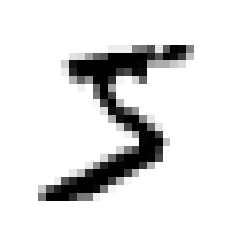

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

MNIST 데이터셋은 훈련세트와 검증세트가 이미 나누어져 있음 (0~60000: 훈련, 60000~ :검증)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련
숫자 5인지 아닌지 분류하는 이진 분류기 예시 (binary classifier)

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

scikit-learn의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(SGD) <br>
매우 큰 데이터셋을 효율적으로 처리하는 장점이 있음 (SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문) <br>
온라인 학습에 잘 들어 맞음

In [11]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit]) # 5를 넣어보자

array([ True])

# 3.3 성능 측정
분류기 평가는 회귀 모델보다 훨씬 어려움
## 3.3.1 교차 검증을 사용한 정확도 측정

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_preds = clone_clf.predict(X_test_fold)
    n_correct = sum(y_preds == y_test_fold) # 맞은 경우를 카운트
    print(n_correct / len(y_preds)) # 전체중의 맞은 경우 (정확도)

0.9669
0.91625
0.96785


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

클래스 불균형 문제이다. 모든 이미지를 5가 아님으로 예측하는 클래스로 분류하는 더미 분류기를 만들어 비교해보자

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

전체 이미지 중에서 10%만 숫자 5이기 때문에 무조건 5아님을 예측하면 확률이 90%이다. <br>
불균형한 데이터셋을 다룰때 정확도를 분류기의 성능 측정 지표로 선호하지 않는다.

## 3.3.2 오차 행렬 (Confusion Matrix)
클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것 <br>
ex) 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알아보자

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) # 실제값, 예측값(cv적용)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차 행렬의 행은 실제 클래스, 열은 예측한 클래스를 나타낸다. (음성, 양성) <br>
53892개는 잘 예측했음 (True Negative) - 정탐 <br>
687개는 잘못 예측 (False Positive) - 오탐 <br>
1891개는 잘못예측 (False Negative) - 미탐 <br>
4096개는 잘 예측 (Ture Positive) - 정탐 <br>

"5를 찾아내야함" 
- 분류기를 속이고 안들킴 (미탐, FN)
- 분류기가 확신을 갖고 분류했지만 틀림 (오탐, FP)

양성 예측 정확도 -> 정밀도 <br>

TP / TP + FP -> 분류기가 분류해낸 것 중에 진짜 맞은것

분류기가 정확하게 감지한 양성 샘플의 비율 -> 재현율

TP / TP + FN -> 미탐과 정탐 중 정확하게 감지한 비율

In [20]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
precision

0.8370879772350012

In [21]:
recall = recall_score(y_train_5, y_train_pred)
recall

0.6511713705958311

정밀도와 재현율의 조화평균 -> F1 score

2 * (정밀도 * 재현율) / (정밀도 + 재현율)

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
2 * (precision * recall) / (precision + recall)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다. 이게 항상 바람직한 것은 아니다. 상황에 따라 정밀도가 중요할 수도 잇고 재현율이 중요할 수도 있다. <br>

정밀도가 높다 -> TP가 높고, FP가 낮음 -> 오탐이 낮음 -> 분류해야할 대상을 못잡는 일이 없음 <br>
재현율이 높다 -> TP가 높고, FN가 낮음 -> 미탐이 낮음 -> 의심이 많아서 도둑을 거의 다 잡음 <br>

## 3.3.4 정밀도/재현율 트레이드 오프
SGDClassifier 는 결정 함수(decision function)를 사용해 샘플의 점수를 계산한다. <br>
이 점수가 임계값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다. <br>
사이킷런에서는 이러한 임계값을 직접 지정할 수 없지만 예측에 사용한 점수는 확인할 수 있다.

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임계값을 높이면 재현율이 줄어든다는 것을 알 수 있다. (미탐이 높아짐) <br>
cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해보자 (decision_function)

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")

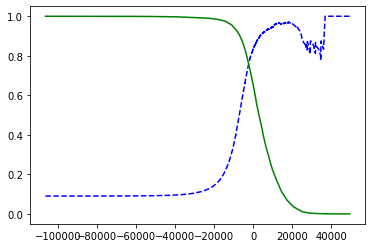

In [35]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

만약 정밀도 90%를 달성하는 것이 프로젝트에 목표라고 가정한다면 임계값은 약 8,000 정도라는 것을 알 수 있다. <br>
조금 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임계값을 찾아보자 (np.zrgmax()를 쓰면 최잿값의 첫 번째 인덱스를 반환한다.)

In [37]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [38]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

누군가 99% 정밀도를 달성하자고 말하면 재현율 얼마에서? 라고 물어봐야 한다.

## 3.3.5 ROC 곡선
receiver operating characteristic(ROC) 곡선도 이진 분류에서 널리 사용함 <br>
정밀도/재현율과 매우 비슷하지만 거짓 양성 비율 (FPR)에 대한 진짜 양성 비율 (TPR) 곡선이다.

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

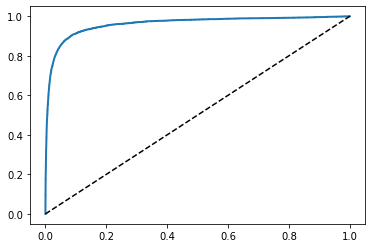

In [43]:
plot_roc_curve(fpr, tpr)
plt.show()

TPR이 높을 수록 분류기가 만드는 거짓 양성 FPR이 늘어난다. 곡선 아래의 면적 (AUC)을 측정하면 분류기들을 비교할 수 있다.<br>
완벽한 분류기는 ROC의 AUC가 1이고 완전 랜덤한 분류기는 0.5다

In [44]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 훈련 시켜 SGDClassifier의 ROC곡선과 ROC AUC 점수를 비교해보자. <br>
두 모델은 동작 방식의 차이 때문에 RandomForestClassifier에는 decision_function() 메서드가 없다. 대신 predict_proba() 메서드를 이용

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [48]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53944 missing from c

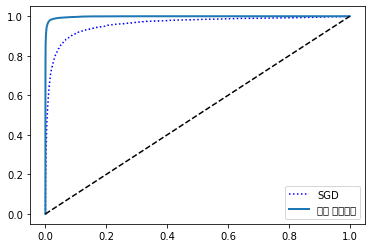

In [49]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

랜덤포레스트가 왼쪽 상단(1)에 가깝고 roc_auc_score 도 훨씬 높다. 

# 3.4 다중 분류
